In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [3]:
# Ensure you have downloaded the stopwords and punkt packages
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0931\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\0931\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load the dataset
dataset = pd.read_csv('tweets.csv',encoding='latin1')

In [97]:
dataset.head()

,Tweet,lable
0,@Vivekk303\nAny Sympathizers of these Anti -In...,1
1,#Hadith \n\n#ProphetMuhammad (PBUH) Said \n\nT...,1
2,#IslamicState Central issues an official photo...,1
3,#IslamicState (IS) Militants Targeted the #Ira...,1
4,Three Different #IslamicState (#Shabaab Cult) ...,1


In [98]:
dataset.tail()

,Tweet,lable
9566,#StopISIS,0
9567,#StopIslam #StopISIS #PrayersForBrussels #JeS...,0
9568,#stopisis klinkt ook prima!!!!!!! https://t.co...,0
9569,im not a muslim but that doesnt stop me from b...,0
9570,#StopISIS https://t.co/RzSIaHbWlW,0


In [99]:
dataset.isna().sum()

Tweet    0
lable    0
dtype: int64

In [100]:
dataset.shape

(9571, 2)

**Description about the dataset**

In [101]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9571 entries, 0 to 9570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   9571 non-null   object
 1   lable   9571 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.7+ KB


In [102]:
dataset.columns

Index(['Tweet', 'lable'], dtype='object')

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
tweet_distribution = dataset['lable'].value_counts()
tweet_distribution

lable
1    5000
0    4571
Name: count, dtype: int64

***Checking the balancing of the target variable***

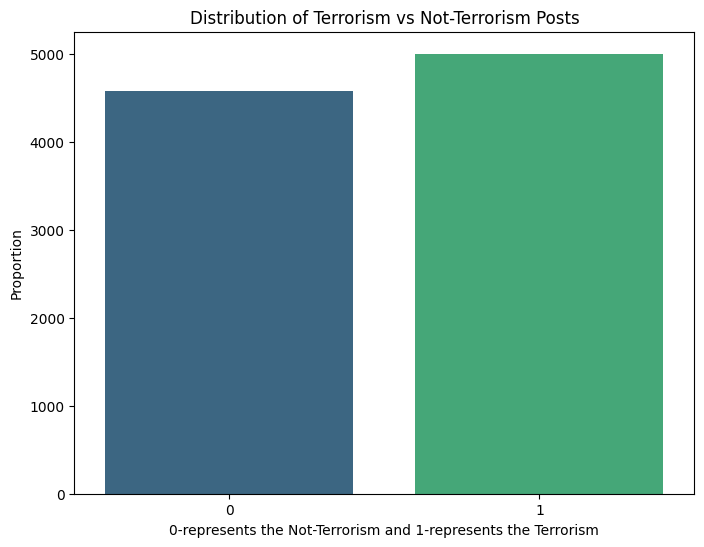

lable
1    5000
0    4571
Name: count, dtype: int64

In [105]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x=tweet_distribution.index, y=tweet_distribution.values, palette='viridis')
plt.title('Distribution of Terrorism vs Not-Terrorism Posts')
plt.xlabel('0-represents the Not-Terrorism and 1-represents the Terrorism')
plt.ylabel('Proportion')
plt.show()

# Displaying the balance of the target variable
tweet_distribution

In [5]:
# Define text preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove whitespace
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [6]:
# Apply the clean_text function
dataset['cleaned_text'] = dataset['Tweet'].apply(clean_text)

In [7]:
# Vectorize the text using HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=5000)
X = vectorizer.fit_transform(dataset['cleaned_text'])
y = dataset['lable']  # Assuming 'label' is the column name for the target variable

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7656, 5000), (1915, 5000), (7656,), (1915,))

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)


print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.997911227154047


[[ 895    3]
 [   1 1016]]


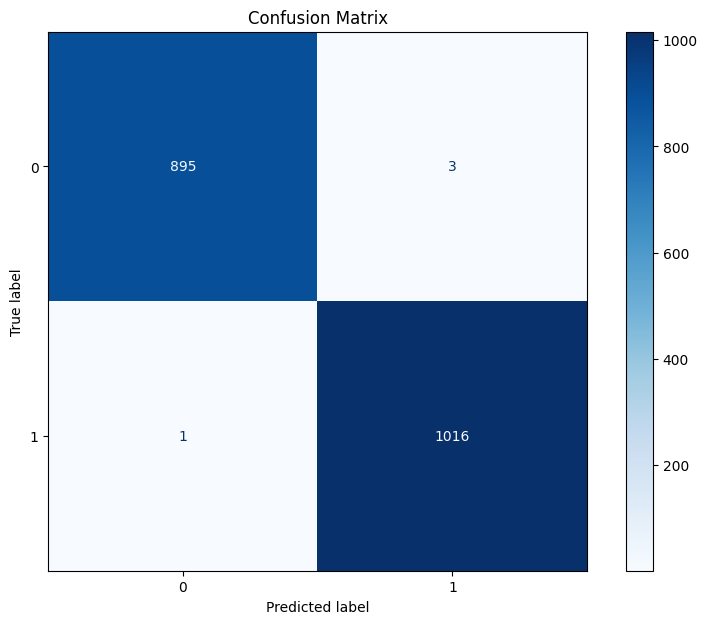

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, rf_preds)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_).plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

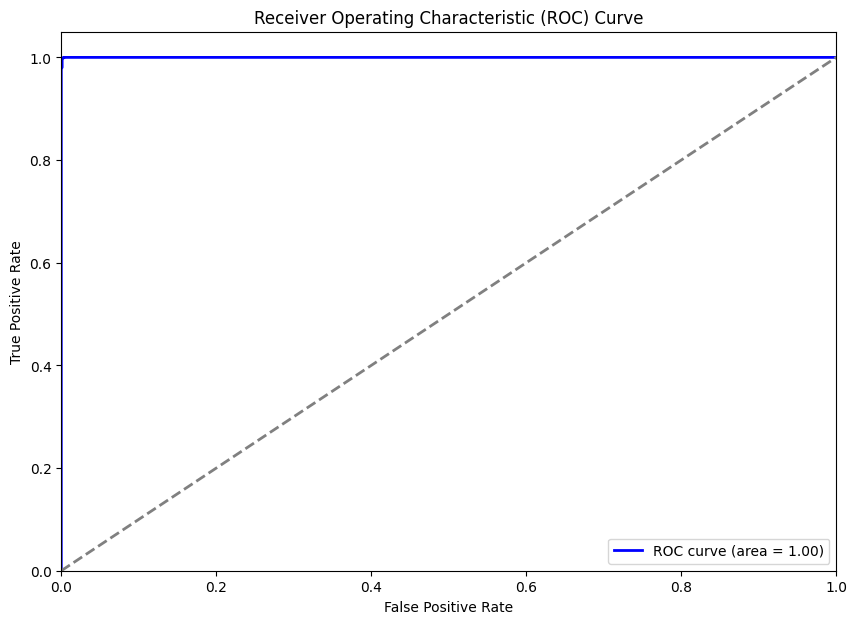

In [112]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [113]:
# Print the classification report
rf = classification_report(y_test, rf_preds)
print("Random Forest Classification Report:\n", rf)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       898
           1       1.00      1.00      1.00      1017

    accuracy                           1.00      1915
   macro avg       1.00      1.00      1.00      1915
weighted avg       1.00      1.00      1.00      1915



In [114]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Convert the sparse matrix to a dense array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Create and train the Naive Bayes model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_dense, y_train)

# Make predictions
naive_bayes_preds = naive_bayes.predict(X_test_dense)

# Calculate accuracy
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_preds)

print("Naive Bayes Accuracy:", naive_bayes_accuracy)


Naive Bayes Accuracy: 0.762402088772846


In [115]:
# Print the classification report
naive_bayes = classification_report(y_test, naive_bayes_preds)
print("Naive Bayes Classification Report:\n",naive_bayes )

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76       898
           1       0.81      0.73      0.77      1017

    accuracy                           0.76      1915
   macro avg       0.76      0.76      0.76      1915
weighted avg       0.77      0.76      0.76      1915



Confusion Matrix:
[[719 179]
 [276 741]]


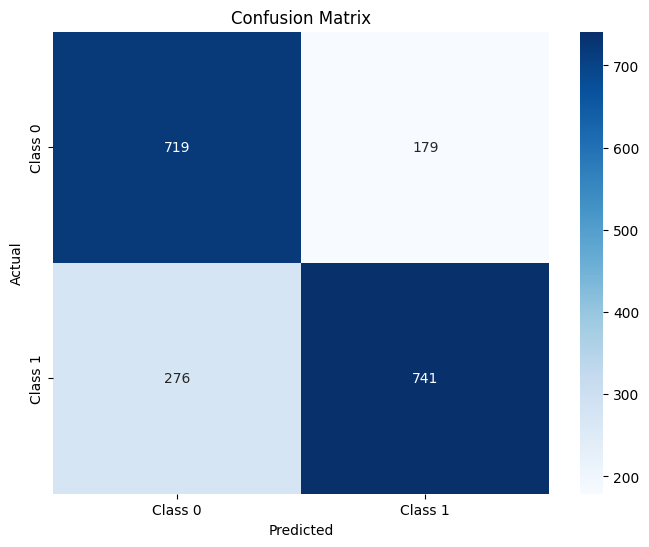

In [116]:
#Generate confusion matrix
cm = confusion_matrix(y_test, naive_bayes_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

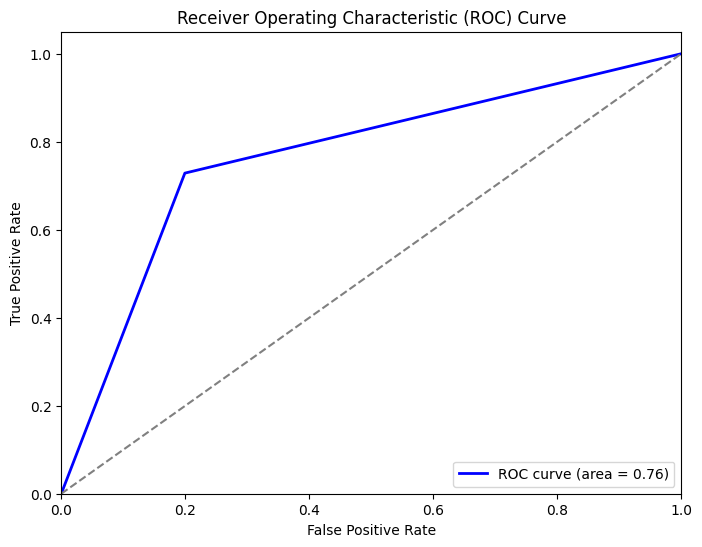

In [117]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, naive_bayes_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Assuming dataset is already loaded and cleaned as per previous steps

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['Tweet'])

X = tokenizer.texts_to_sequences(dataset['Tweet'])
X = pad_sequences(X, maxlen=100)

# Splitting the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train1, y_train1, epochs=5, batch_size=64, validation_data=(X_test1, y_test1), verbose=2)
# Saving the model and tokenizer
model.save('LSTM_Model.h5')
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Evaluating the model
lstm_accuracy = model.evaluate(X_test1, y_test1, verbose=0)[1]
print("LSTM Accuracy:", lstm_accuracy)

# Predicting using the LSTM model
y_pred = (model.predict(X_test1) > 0.5).astype("int32")

# Generating the classification report
lstm_classification_report = classification_report(y_test1, y_pred)
print("LSTM Classification Report:\n", lstm_classification_report)




Epoch 1/5
120/120 - 37s - loss: 0.2222 - accuracy: 0.9185 - val_loss: 0.0261 - val_accuracy: 0.9937 - 37s/epoch - 307ms/step
Epoch 2/5
120/120 - 34s - loss: 0.0155 - accuracy: 0.9969 - val_loss: 0.0138 - val_accuracy: 0.9958 - 34s/epoch - 282ms/step
Epoch 3/5
120/120 - 33s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0139 - val_accuracy: 0.9958 - 33s/epoch - 273ms/step
Epoch 4/5
120/120 - 30s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0232 - val_accuracy: 0.9937 - 30s/epoch - 252ms/step
Epoch 5/5
120/120 - 29s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0361 - val_accuracy: 0.9911 - 29s/epoch - 241ms/step


C:\Users\0931\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM Accuracy: 0.9911227226257324
60/60 [==============================] - 2s 24ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       898
           1       0.98      1.00      0.99      1017

    accuracy                           0.99      1915
   macro avg       0.99      0.99      0.99      1915
weighted avg       0.99      0.99      0.99      1915



Confusion Matrix:
 [[ 882   16]
 [   1 1016]]


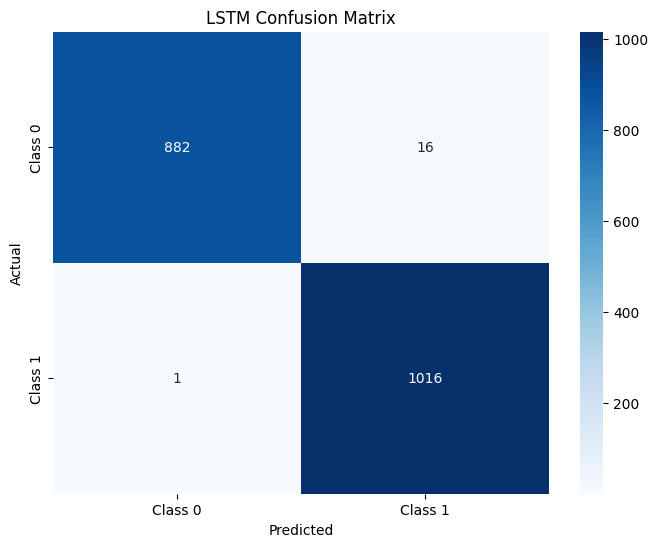

In [119]:
# Generating the confusion matrix
lstm_confusion_matrix = confusion_matrix(y_test1, y_pred)
print("Confusion Matrix:\n", lstm_confusion_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Assuming dataset is already loaded and cleaned as per previous steps

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['Tweet'])

X = tokenizer.texts_to_sequences(dataset['Tweet'])
X = pad_sequences(X, maxlen=100)

# Splitting the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the GRU model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train1, y_train1, epochs=5, batch_size=64, validation_data=(X_test1, y_test1), verbose=2)

# Saving the model and tokenizer
model.save('GRU_Model.h5')
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Evaluating the model
gru_accuracy = model.evaluate(X_test1, y_test1, verbose=0)[1]
print("GRU Accuracy:", gru_accuracy)

# Predicting using the GRU model
y_pred = (model.predict(X_test1) > 0.5).astype("int32")

# Generating the classification report
gru_classification_report = classification_report(y_test1, y_pred)
print("GRU Classification Report:\n", gru_classification_report)


Epoch 1/5
120/120 - 32s - loss: 0.1875 - accuracy: 0.9319 - val_loss: 0.0094 - val_accuracy: 0.9984 - 32s/epoch - 263ms/step
Epoch 2/5
120/120 - 29s - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.0085 - val_accuracy: 0.9984 - 29s/epoch - 245ms/step
Epoch 3/5
120/120 - 25s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0064 - val_accuracy: 0.9974 - 25s/epoch - 212ms/step
Epoch 4/5
120/120 - 26s - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0054 - val_accuracy: 0.9990 - 26s/epoch - 219ms/step
Epoch 5/5
120/120 - 28s - loss: 5.8520e-04 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9990 - 28s/epoch - 231ms/step


C:\Users\0931\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


GRU Accuracy: 0.9989556074142456
60/60 [==============================] - 2s 21ms/step
GRU Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       898
           1       1.00      1.00      1.00      1017

    accuracy                           1.00      1915
   macro avg       1.00      1.00      1.00      1915
weighted avg       1.00      1.00      1.00      1915



Confusion Matrix:
 [[ 897    1]
 [   1 1016]]


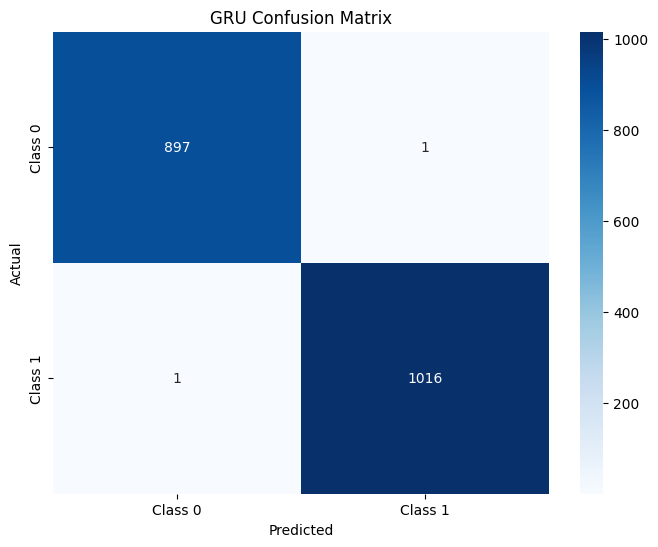

In [121]:
# Generating the confusion matrix
gru_confusion_matrix = confusion_matrix(y_test1, y_pred)
print("Confusion Matrix:\n", gru_confusion_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(gru_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GRU Confusion Matrix')
plt.show()

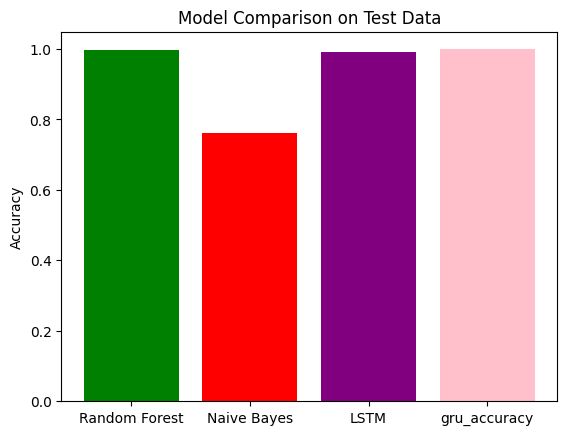

In [122]:
# Plotting the graphs 
accuracies = [rf_accuracy, naive_bayes_accuracy, lstm_accuracy,gru_accuracy]
model_names = ['Random Forest', 'Naive Bayes', 'LSTM','gru_accuracy']

plt.bar(model_names, accuracies, color=['green', 'red', 'purple','pink'])
plt.ylabel('Accuracy')
plt.title('Model Comparison on Test Data')
plt.show()

In [ ]:
# Assuming the preprocessing function and the trained model are already defined
# Function to preprocess and predict using the LSTM model
import pickle
def preprocess_and_predict(sentence):
    # Preprocess the input sentence
    clean_sentence = clean_text(sentence)
    
    # Load the tokenizer and LSTM model
    with open('tokenizer.pkl', 'rb') as file:
        tokenizer = pickle.load(file)
    model = tf.keras.models.load_model('GRU_Model.h5')
    
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([clean_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    
    # Make the prediction
    result = model.predict(padded_sequence)
    
    # Interpret and print the result
    if result > 0.5:
        print('Terrorism')
    else:
        print('Not Terrorism')

# Example usage
sentence = """Check out my latest FrontPage piece... Brother of #AlQaeda Commander Becomes Admin at South Florida #ISIS Imam School; 
The younger sibling of dead al-Qaeda leader Adnan Shukrijumah moves a step closer to. https://t.co/WhU05Mop0C"""
preprocess_and_predict(sentence)

1/1 [==============================] - 0s 301ms/step
Terrorism


In [12]:
# Assuming the preprocessing function and the trained model are already defined
# Function to preprocess and predict using the LSTM model
def preprocess_and_predict(sentence):
    # Preprocess the input sentence
    clean_sentence = clean_text(sentence)
    
    # Load the tokenizer and LSTM model
    with open('tokenizer.pkl', 'rb') as file:
        tokenizer = pickle.load(file)
    model = tf.keras.models.load_model('GRU_Model.h5')
    
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([clean_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    
    # Make the prediction
    result = model.predict(padded_sequence)
    
    # Interpret and print the result
    if result > 0.5:
        print('Terrorism')
    else:
        print(' Not Terrorism')

# Example usage
sentence = "Hoy ha sido IrÃ¡n, que pare ya esta barbarie, basta ya! #StopISIS #PrayForTheWorld #Peace"
preprocess_and_predict(sentence)

1/1 [==============================] - 0s 342ms/step
 Not Terrorism
